# Lab 05 : Advantageous Actor-Critic (A2C) - demo


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = 'A2C_actor_critic_demo.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [1]:

import torch
import torch.nn as nn
torch.manual_seed(torch.randint(10000,())) # random seed for pythorch random generator

import time
import numpy as np

import os
import pickle

import gym

import matplotlib
import matplotlib.pyplot as plt
from IPython import display

from collections import namedtuple
import random
from itertools import count

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self
        

# Dataset

In [2]:

#Env parameters
env_seed = 1
render = True # display on
render = False # display off

#Initialize the environment with the same seed/initialization value
env = gym.make('CartPole-v0')
env.seed(env_seed)

#Reset the environment
state = env.reset() 
print('init state:',state)

#Rollout one episode until it finishes 
for t in count():  
    action = torch.LongTensor(1).random_(0,2).item() # randomly generated action=a in {0,1}
    state, reward, done, _ = env.step(action) # receive next state=s' and reward=r
    print('t=',t, 'action=',action, 'state=',np.array_str(state, precision=5), 'reward=',reward, 'done=',done )
    if render:
        env.render() # see the state
    if done:
        break


init state: [ 0.03073904  0.00145001 -0.03088818 -0.03131252]
t= 0 action= 0 state= [ 0.03077 -0.19322 -0.03151  0.25147] reward= 1.0 done= False
t= 1 action= 1 state= [ 0.0269   0.00234 -0.02649 -0.05099] reward= 1.0 done= False
t= 2 action= 0 state= [ 0.02695 -0.19239 -0.0275   0.23322] reward= 1.0 done= False
t= 3 action= 0 state= [ 0.0231  -0.38711 -0.02284  0.5171 ] reward= 1.0 done= False
t= 4 action= 1 state= [ 0.01536 -0.19167 -0.0125   0.21731] reward= 1.0 done= False
t= 5 action= 0 state= [ 0.01153 -0.38661 -0.00815  0.50603] reward= 1.0 done= False
t= 6 action= 1 state= [ 0.00379 -0.19138  0.00197  0.21079] reward= 1.0 done= False
t= 7 action= 1 state= [-3.27300e-05  3.71557e-03  6.18426e-03 -8.12748e-02] reward= 1.0 done= False
t= 8 action= 0 state= [ 4.15813e-05 -1.91494e-01  4.55876e-03  2.13353e-01] reward= 1.0 done= False
t= 9 action= 0 state= [-0.00379 -0.38668  0.00883  0.50747] reward= 1.0 done= False
t= 10 action= 1 state= [-0.01152 -0.19168  0.01898  0.21758] rewar

# Define the policy network

In [3]:

# class of policy network
class ActorCritic_NN(nn.Module): 
    
    def __init__(self, net_parameters):
        super(ActorCritic_NN, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        # policy network
        self.fc1_p = nn.Linear(input_dim, hidden_dim)
        self.fc2_p = nn.Linear(hidden_dim, output_dim)
        # state-value function network
        self.fc1_q_sv = nn.Linear(input_dim, hidden_dim)
        self.fc2_q_sv = nn.Linear(hidden_dim, output_dim)
        # state function network
        self.fc1_q_s = nn.Linear(input_dim, hidden_dim)
        self.fc2_q_s = nn.Linear(hidden_dim, 1)

    def forward_policy(self, x):
        x = torch.relu(self.fc1_p(x))
        actions_score = self.fc2_p(x)
        actions_prob = torch.softmax(actions_score, dim=1)
        return actions_prob
    
    def forward_Q_sv(self, x):
        x = torch.relu(self.fc1_q_sv(x))
        Q_scores = self.fc2_q_sv(x) # scores over actions 
        return Q_scores
    
    def forward_Q_s(self, x):
        x = torch.relu(self.fc1_q_s(x))
        Q_scores = self.fc2_q_s(x) # scores over actions 
        return Q_scores
    
    def select_action(self, state): # select action w/ policy network
        probs = self.forward_policy(state) # probability of action a in state s
        bernoulli_sampling = torch.distributions.Categorical(probs) 
        action = bernoulli_sampling.sample() # sample action a with Bernoulli sampling
        return action

    def loss(self, batch):
        gamma = opt_parameters['gamma']
        nb_episodes_per_batch = len(batch.states)
        batch_losses = []
        for episode in range(nb_episodes_per_batch):
            episode_states = torch.stack( batch.states[episode] ).float() #size=B x 4     
            episode_next_states = torch.stack( batch.next_states[episode] ).float() #size=B x 4  
            episode_actions = torch.stack( batch.actions[episode] ).long() #size=B
            episode_rewards = - torch.stack( batch.rewards[episode] ).float() #size=B
            episode_dones = torch.stack( batch.dones[episode] ).float() #size=B
            R = 0; policy_loss = []; rewards = []
            for r in batch.rewards[episode][::-1]: # compute the discarded award at each time step
                R = r + gamma * R
                rewards.insert(0, R)
            episode_discounted_rewards = torch.tensor(rewards).float() #size=B
            episode_next_actions = self.select_action(episode_next_states) #size=B
            Q = self.forward_Q_sv(episode_states).gather(dim=1,index=episode_actions.unsqueeze(1)) # Qv(a|s), size=B x 1
            Q_target = episode_rewards.unsqueeze(1) + gamma *  \
                self.forward_Q_sv(episode_next_states).gather(dim=1,index=episode_next_actions.unsqueeze(1)) * episode_dones.unsqueeze(1)
            Q_state = self.forward_Q_s(episode_states)
            logP = torch.log( actorcritic_net.forward_policy(episode_states).gather(dim=1,index=episode_actions.unsqueeze(1)) )
            loss1 = ( -logP * (Q-Q_state).detach() ).mean()
            loss2 = nn.MSELoss()(Q,Q_target.detach())
            loss3 = nn.MSELoss()(Q_state,episode_discounted_rewards.unsqueeze(1).detach())
            loss = loss1 + loss2 + loss3
            batch_losses.append(loss)
        loss = torch.stack(batch_losses).mean()
        return loss

        
# class of rollout episodes
class Rollout_Episodes():
    
    def __init__(self,):
        super(Rollout_Episodes, self).__init__()
    
    def rollout_batch_episodes(self, env, opt_parameters, actorcritic_net, write_memory=True):
        # storage structure of all episodes (w/ different lengths)
        nb_episodes_per_batch = opt_parameters['nb_episodes_per_batch']
        env_seeds = opt_parameters['env_seed']
        batch = DotDict()
        batch.states=[];  batch.actions=[]; batch.next_states=[]; batch.rewards=[]; batch.dones=[]
        batch_episode_lengths = []
        for episode in range(nb_episodes_per_batch):
            states=[]; actions=[]; next_states=[]; rewards=[]; dones = []
            env.seed(env_seeds[episode].item()) # start with random seed
            state = env.reset() # reset environment
            for t in range(1000): # rollout one episode 
                state_pytorch = torch.from_numpy(state).float().unsqueeze(0) # state=s
                action = actorcritic_net.select_action(state_pytorch).item() # select action=a from state=s
                next_state, reward, done, _ = env.step(action) # receive next state=s' and reward=r
                done_mask = 0.0 if done else 1.0
                states.append(torch.tensor(state))
                actions.append(torch.tensor(action))
                next_states.append(torch.tensor(next_state))
                rewards.append(torch.tensor(reward))
                dones.append(torch.tensor(done_mask))
                state = next_state
                if done:
                    batch_episode_lengths.append(t)
                    break
            batch.states.append(states)
            batch.actions.append(actions)
            batch.next_states.append(next_states)
            batch.rewards.append(rewards)
            batch.dones.append(dones)
        return batch_episode_lengths, batch

        
    
# network parameters
net_parameters = {}
net_parameters['input_dim'] = 4
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 2

# instantiate network
actorcritic_net = ActorCritic_NN(net_parameters)
print(actorcritic_net)

# instantiate rollout
rollout_policy_net = Rollout_Episodes()

# optimization parameters
opt_parameters = {}
opt_parameters['nb_episodes_per_batch'] = 3
opt_parameters['env_seed'] = torch.LongTensor(opt_parameters['nb_episodes_per_batch']).random_(1,10000)

env = gym.make('CartPole-v0')

batch_episode_lengths, batch = rollout_policy_net.rollout_batch_episodes(env, opt_parameters, actorcritic_net)
#print('batch:',batch)
print('batch_episode_lengths:',batch_episode_lengths)


ActorCritic_NN(
  (fc1_p): Linear(in_features=4, out_features=128, bias=True)
  (fc2_p): Linear(in_features=128, out_features=2, bias=True)
  (fc1_q_sv): Linear(in_features=4, out_features=128, bias=True)
  (fc2_q_sv): Linear(in_features=128, out_features=2, bias=True)
  (fc1_q_s): Linear(in_features=4, out_features=128, bias=True)
  (fc2_q_s): Linear(in_features=128, out_features=1, bias=True)
)
batch_episode_lengths: [39, 26, 9]


# Test forward pass

In [4]:

# optimization parameters
opt_parameters = {}
opt_parameters['lr'] = 0.001
opt_parameters['nb_episodes_per_batch'] = 3
opt_parameters['env_seed'] = torch.LongTensor(opt_parameters['nb_episodes_per_batch']).random_(1,10000)
opt_parameters['gamma'] = 0.99

batch_episode_lengths, batch = rollout_policy_net.rollout_batch_episodes(env, opt_parameters, actorcritic_net)
#print('batch:',batch)
print('batch_episode_lengths:',batch_episode_lengths)


batch_episode_lengths: [14, 29, 16]


# Test backward pass

In [5]:

# Loss
loss = actorcritic_net.loss(batch)
print('loss:',loss)

# Backward pass
lr = opt_parameters['lr']
optimizer = torch.optim.Adam(actorcritic_net.parameters(), lr=lr)
optimizer.zero_grad()
loss.backward()
optimizer.step()


loss: tensor(141.9592, grad_fn=<MeanBackward0>)


# Train one epoch

In [6]:

def train_one_epoch(env, actorcritic_net, opt_parameters):
    """
    train one epoch
    """
    actorcritic_net.train()
    epoch_loss = 0
    nb_data = 0
    epoch_episode_length = 0
    epoch_episode_lengths = []
    nb_batches_per_epoch = opt_parameters['nb_batches_per_epoch']
    for iter in range(nb_batches_per_epoch):
        batch_episode_lengths, batch = \
            rollout_policy_net.rollout_batch_episodes(env, opt_parameters, actorcritic_net)
        loss = actorcritic_net.loss(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        nb_data += len(batch_episode_lengths)
        epoch_episode_length += torch.tensor(batch_episode_lengths).float().sum()
        epoch_episode_lengths.append(epoch_episode_length)
    epoch_loss /= nb_data
    epoch_episode_length /= nb_data
    return epoch_loss, epoch_episode_length, epoch_episode_lengths



# Train NN

In [7]:

# network parameters
net_parameters = {}
net_parameters['input_dim'] = 4
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = 2

# instantiate network
actorcritic_net = ActorCritic_NN(net_parameters)
print(actorcritic_net)

# optimization parameters
opt_parameters = {}
opt_parameters['lr'] = 0.0005
opt_parameters['nb_episodes_per_batch'] = 1
opt_parameters['nb_batches_per_epoch'] = 50
opt_parameters['env_seed'] = torch.LongTensor(opt_parameters['nb_episodes_per_batch']).random_(1,10000)
opt_parameters['gamma'] = 0.99

optimizer = torch.optim.Adam(actorcritic_net.parameters(), lr=opt_parameters['lr'] )

# select maximum episode length to learn
env = gym.make('CartPole-v0')
env._max_episode_steps = 400 # 200 400
env.spec.reward_threshold = 0.975* env._max_episode_steps
print('env._max_episode_steps',env._max_episode_steps)

# train loop
all_epoch_lengths = []
start = time.time()
for epoch in range(500): 
    
    # train one epoch
    epoch_train_loss, epoch_episode_length, epoch_episode_lengths = train_one_epoch(env, actorcritic_net, opt_parameters)
 
    # stop training when reward is high
    if epoch_episode_length > env.spec.reward_threshold:
        print('Training done.')
        print("Last episode length is {}, epoch is {}".
              format(epoch_episode_length, epoch))
        break

    # print intermediate info
    if not epoch%1:
        print('Epoch: {}, time: {:.4f}, train_loss: {:.4f}, episode_length: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_episode_length))
        
    # plot all epochs
    all_epoch_lengths.append(epoch_episode_length)
    if not epoch%1:
        plt.figure(2)
        plt.title('Training...')
        plt.xlabel('Epochs')
        plt.ylabel('Length of episodes batch')
        plt.plot(torch.Tensor(all_epoch_lengths).numpy())
        plt.pause(0.001)
        display.clear_output(wait=True)


Training done.
Last episode length is 395.20001220703125, epoch is 45


Last episode length is 395.20001220703125, epoch is 45


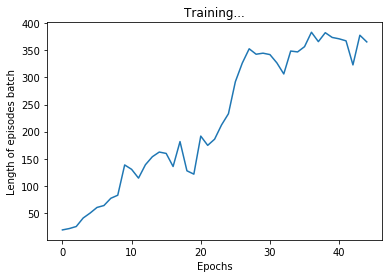

In [8]:
# Final plot
plt.figure(2)
plt.title('Training...')
plt.xlabel('Epochs')
plt.ylabel('Length of episodes batch')
plt.plot(torch.Tensor(all_epoch_lengths).numpy())
print("Last episode length is {}, epoch is {}".format(epoch_episode_length, epoch))
       

# Run it longer

In [11]:

env._max_episode_steps = 5000

state = env.reset() # reset environment
for t in range(env._max_episode_steps): # rollout one episode until it finishes or stop after 200 steps
    state_pytorch = torch.from_numpy(state).float().unsqueeze(0) # state=s
    action = actorcritic_net.eval().select_action(state_pytorch).item()
    state, reward, done, _ = env.step(action) # receive next state=s' and reward=r
    env.render() # visualize state
    if done:
        print(t)
        break
        

621
